In [1]:
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture, aperture_photometry, CircularAnnulus, DAOStarFinder
import astropy.io.fits as pf
import numpy as np
import seaborn as sns
sns.set()
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import os
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project')
file = 'wcsF_0013.fits'
image = pf.open(file)
w = WCS(image[0].header)
sky = w.pixel_to_world(100,100)
print(sky)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (82.23549927, 42.48556882)>


In [3]:
x = [82.150936,82.110034,82.158453,82.197666,82.182192,82.192476,82.113757,82.104471,82.095256,82.125836]
y = [42.449436,42.452321,42.478781,42.42245,42.480211,42.437444,42.478844,42.440872,42.420703,42.407897]
a = []
b = []
for i,j in zip(x,y):
    px, py = w.wcs_world2pix(i,j, 1)
    a.append(px)
    b.append(py)
    #print('{0} {1}'.format(px, py))
    
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project\2I Reduced')
file = 'reduceducdF_0013.fits'
image = pf.getdata(file)

a = np.array(a)
b = np.array(b)
a = a
b = b
print(a)
print(b)
mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'

positions = []
for i,j in zip(a,b):
    ID = []
    xref = i
    yref = j
    for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
        if -5<(k-xref)<5 and -5<(l-yref)<5:
            n = m-1
            ID.append(n)
            positions.append((k,l))
    print(sources[ID])

[457.53718273 631.38050569 427.1294207  257.61830175 326.4377114
 280.47764954 616.85975841 654.45515884 692.63986454 562.07895073]
[311.85599402 296.79965591 143.04089804 465.00569645 133.90393555
 379.10434041 144.34339363 362.75072467 478.90847437 551.352699  ]
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
233 455.24569 308.11265 0.89135166 ...   0 102.39025 18.293242 -3.1557267
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
221   630.326  293.7692 0.62543168 ...   0 31.765484 7.0821359 -2.1254106
 id xcentroid ycentroid sharpness ... sky    peak      flux      mag    
--- --------- --------- --------- ... --- --------- --------- ----------
111 425.92943 141.46023 0.4797307 ...   0 423.20584 122.28519 -5.2184347
 id xcentroid ycentroid sharpness ... sky    peak      flux      mag   


In [4]:
mags = []
magserrors = []
for i in positions:
    aperture = CircularAperture(i, r=3) 
    annulus_aperture = CircularAnnulus(i, r_in=12., r_out=15.)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(image, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_total = bkg_mean * aperture.area
    net_star = phot_table['aperture_sum_0'] - bkg_total
    mags.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
    dfdx = -1.08574/phot_table['aperture_sum_0'][0]
    error = np.sqrt((dfdx**2)*(np.sqrt(phot_table['aperture_sum_0'][0]))**2)
    magserrors.append(error)

Beta: [  0.84999622 -19.75765219]
Beta Std Error: [0.04054511 0.52667304]
Beta Covariance: [[ 0.03172729 -0.40823196]
 [-0.40823196  5.3535047 ]]
Residual Variance: 0.0518136254024216
Inverse Condition #: 0.05204359885676856
Reason(s) for Halting:
  Sum of squares convergence


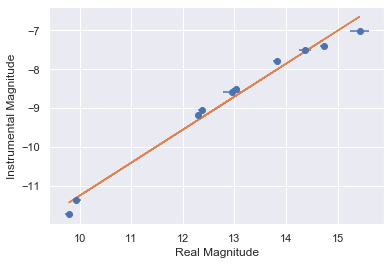

In [5]:
mags = np.array(mags)
Vmag = [15.758,16.402,13.119,15.872,13.806,10.272,12.923,14.323,11.868,14.98]
Vmag = np.array(Vmag)
Vmagerrors = [0.036,0.054,0.037,0.041,0.057,0.041,0.049,0.063,0.058,0.066]


rprime = [15.226,15.971,12.940,15.474,13.608,10.316,12.843,13.891,11.167,14.691]
rprimeerror = [0.13,0.15,0.026,0.068,0.046,0.033,0.027,0.041,0.033,0.071]

iprime = [14.84,15.842,12.726,15.178,13.39,10.326,12.771,13.502,10.349,14.299]
iprimeerror = [0.09,0.15,0.026,0.052,0.15,0.074,0.054,0.067,0.07,0.062,0.043]

Imag = []
Imagerror = []
for rp, ip, rperror, iperror in zip(rprime,iprime,rprimeerror,iprimeerror):
    r = rp +0.035*(rp-ip-0.21)
    rdrp = 1.035
    rdip = -0.035
    rerror = np.sqrt((rdrp**2)*rperror**2+(rdip**2)*iperror**2)
    
    i = ip + 0.041*(rp-ip-0.21)
    idrp = 0.041
    idip = 0.959
    ierror = np.sqrt((idrp**2)*rperror**2+(idip**2)*iperror**2)
    
   
    I = r-1.2444*(r-i)-0.382
    dr = -0.2444
    di = -1.2444
    Ierror = np.sqrt((dr**2)*(rerror**2)+(di**2)*(ierror**2))
    
    Imag.append(I)
    Imagerror.append(Ierror)
Imag = np.array(Imag)
Imagerror = np.array(Imagerror)



plt.errorbar(Imag,mags,xerr=Imagerror,yerr=magserrors,fmt='o')
plt.ylabel('Instrumental Magnitude')
plt.xlabel('Real Magnitude')

def func(p, x):
    m, c = p
    return m*x + c
mydata = odr.RealData(Imag, mags, sx = Imagerror, sy = None)
linear = odr.Model(func)
myodr = odr.ODR(mydata, linear,beta0 =[1, -23])
myoutput = myodr.run()
y = myoutput.beta[0]*Imag+myoutput.beta[1]
plt.plot(Imag,y)
myoutput.pprint()

In [7]:
xref = 403
yref = 377

mean, median, std = sigma_clipped_stats(image, sigma=5)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'
ID = []
for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
    if -10<(k-xref)<10 and -10<(l-yref)<10:
        n = m-1
        ID.append(n)
print(sources[ID])

 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
259 402.69174 377.50359 0.44795732 ...   0 14382.439  4159.048  -9.0474848
268 394.56663 385.54285 0.95846721 ...   0 14.976372 1.1277068 -0.13049048


In [8]:
sourcemag = []
sourcemagerror = []
position = [(402.69174,377.50359)]
aperture = CircularAperture(position[0], r=3) 
annulus_aperture = CircularAnnulus(position[0], r_in=12., r_out=15.)
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total
sourcemag.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
sourcemagerror.append((-1.08574/phot_table['aperture_sum_0'][0])*np.sqrt(phot_table['aperture_sum_0'][0]))
print(sourcemag)

[-13.013816516357888]


In [9]:
dy = 1/myoutput.beta[0]
dc = -1/myoutput.beta[0]
dm = (myoutput.beta[1]-sourcemag[0])/(myoutput.beta[0])**2
error = np.sqrt((dy**2)*sourcemagerror[0]**2+(dc**2)*(myoutput.sd_beta[1])**2+(dm**2)*(myoutput.sd_beta[0])**2)
print((sourcemag[0]-myoutput.beta[1])/myoutput.beta[0],'+/-',error)

7.9339595599114245 +/- 0.7260599941010258
